In [31]:
import os
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [32]:
# === 1. CONFIGURATION ===
DATA_ROOT = Path("data")
XYZ_DIR = DATA_ROOT / "atoms" / "train"
ENERGY_CSV = DATA_ROOT / "energies" / "train.csv"

# === 2. UTILS ===
ATOM_TYPES = ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']

# Valence maximale par type d’atome
VALENCE_MAX = {
    'H': 1,
    'C': 4,
    'N': 3,
    'O': 2,
    'F': 1,
    'S': 6,
    'Cl': 1
}


def atom_to_int(symbol):
    return ATOM_TYPES.index(symbol)

def z_to_one_hot(z, num_classes=7):
    return F.one_hot(z, num_classes=num_classes).float()

# def build_edge_index(pos, cutoff=1.5):
#     dist = torch.cdist(pos, pos)
#     mask = (dist < cutoff) & (dist > 0)
#     row, col = torch.where(mask)
#     edge_index = torch.stack([row, col], dim=0)
#     return edge_index
def build_edge_index(pos, z, cutoff=1.5):
    dist = torch.cdist(pos, pos)
    mask = (dist < cutoff) & (dist > 0)
    row, col = torch.where(mask)
    
    edges = list(zip(row.tolist(), col.tolist()))
    
    # Compter les connexions par atome
    connections = {i: [] for i in range(len(z))}
    edge_scores = {}

    for i, j in edges:
        d = dist[i, j].item()
        connections[i].append((j, d))
        edge_scores[(i, j)] = d

    final_edges = []
    for i in connections:
        # Limiter au nombre de liaisons maximum
        symbol = int_to_atom(z[i].item())
        max_conn = VALENCE_MAX[symbol]
        
        # Trier les voisins par distance croissante
        neighbors = sorted(connections[i], key=lambda x: x[1])
        selected = neighbors[:max_conn]

        for j, _ in selected:
            final_edges.append((i, j))

    # Éviter les doublons (i,j) et (j,i)
    final_edges = list(set(final_edges))
    row, col = zip(*final_edges)
    edge_index = torch.tensor([row, col], dtype=torch.long)
    return edge_index


def int_to_atom(index):
    return ATOM_TYPES[index]

In [33]:
# === 3. DATASET ===
class QM7XDataset(Dataset):
    def __init__(self, xyz_dir, energy_csv, cutoff=1.8):
        super().__init__()
        self.xyz_dir = xyz_dir
        self.cutoff = cutoff
        self.energy_df = pd.read_csv(energy_csv, index_col='id')

    def __len__(self):
        return len(self.energy_df)

    def _load_xyz(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()[2:]
        atoms = []
        positions = []
        for line in lines:
            parts = line.split()
            atoms.append(atom_to_int(parts[0]))
            positions.append([float(x) for x in parts[1:4]])
        z = torch.tensor(atoms, dtype=torch.long)
        pos = torch.tensor(positions, dtype=torch.float)
        return z, pos

    def __getitem__(self, idx):
        mol_id = idx + 1
        file_path = self.xyz_dir / f"id_{mol_id}.xyz"
        z, pos = self._load_xyz(file_path)
        x = z_to_one_hot(z)
        edge_index = build_edge_index(pos, z, self.cutoff)

        energy = torch.tensor([self.energy_df.loc[mol_id, 'energy']], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, pos=pos, y=energy)
        return data


In [34]:
dataset = QM7XDataset(XYZ_DIR, ENERGY_CSV)

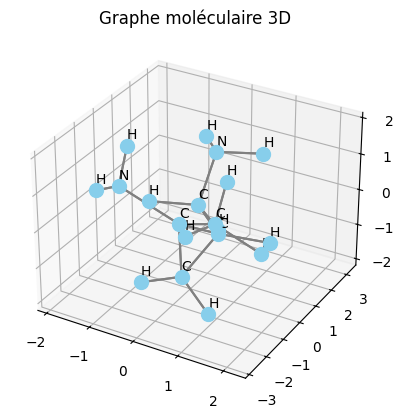

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Charger un échantillon du dataset
data = dataset[10]

# 2. Extraire les types d’atomes (indices) et les convertir en symboles
atom_types = data.x.argmax(dim=1)  # indices
atom_labels = [int_to_atom(i.item()) for i in atom_types]

# 3. Tracer les positions et liaisons
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Décalage vertical pour éviter le chevauchement (en Ångströms)
offset = 0.2

# Atomes
for i, pos in enumerate(data.pos):
    x, y, z = pos.tolist()
    ax.scatter(x, y, z, s=100, c='skyblue')  # sphère atomique
    ax.text(x, y, z + offset, atom_labels[i], fontsize=10, color='black')  # étiquette au-dessus

# Arêtes
for i, j in data.edge_index.t().tolist():
    p1 = data.pos[i].tolist()
    p2 = data.pos[j].tolist()
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c='gray')

ax.set_title("Graphe moléculaire 3D")
plt.show()



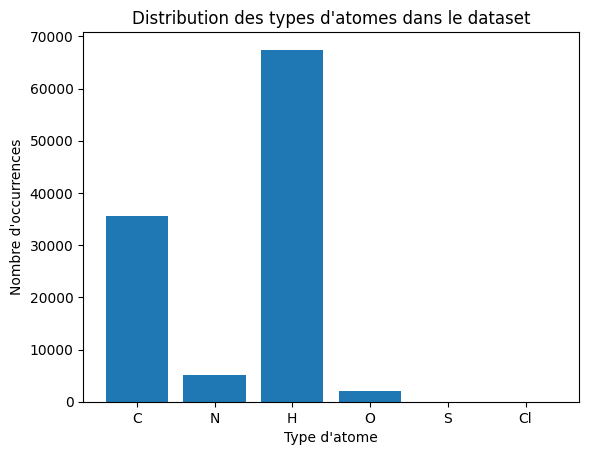

In [36]:
from collections import Counter
all_atoms = []

for i in range(len(dataset)):
    data = dataset[i]
    atom_types = data.x.argmax(dim=1).tolist()
    all_atoms.extend(atom_types)

counts = Counter(all_atoms)
labels = [int_to_atom(i) for i in counts.keys()]
values = list(counts.values())

plt.bar(labels, values)
plt.xlabel("Type d'atome")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des types d'atomes dans le dataset")
plt.show()


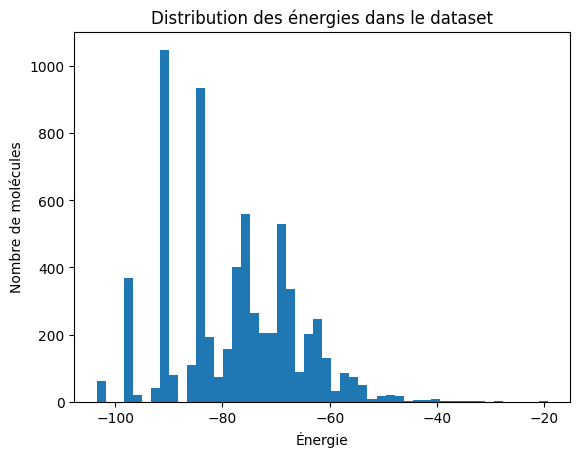

In [37]:
energies = [dataset[i].y.item() for i in range(len(dataset))]
plt.hist(energies, bins=50)
plt.xlabel("Énergie")
plt.ylabel("Nombre de molécules")
plt.title("Distribution des énergies dans le dataset")
plt.show()


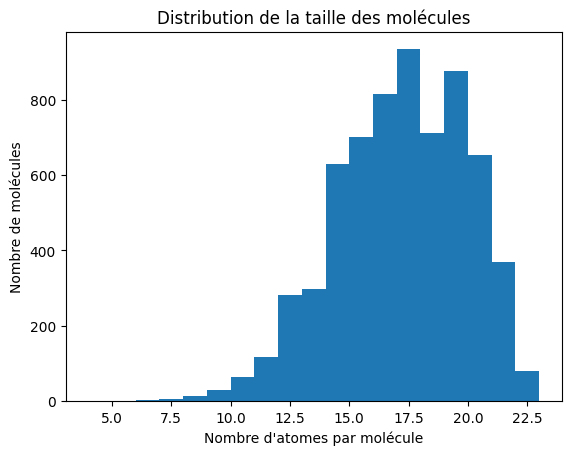

In [38]:
sizes = [dataset[i].x.size(0) for i in range(len(dataset))]
plt.hist(sizes, bins=range(min(sizes), max(sizes)+1))
plt.xlabel("Nombre d'atomes par molécule")
plt.ylabel("Nombre de molécules")
plt.title("Distribution de la taille des molécules")
plt.show()


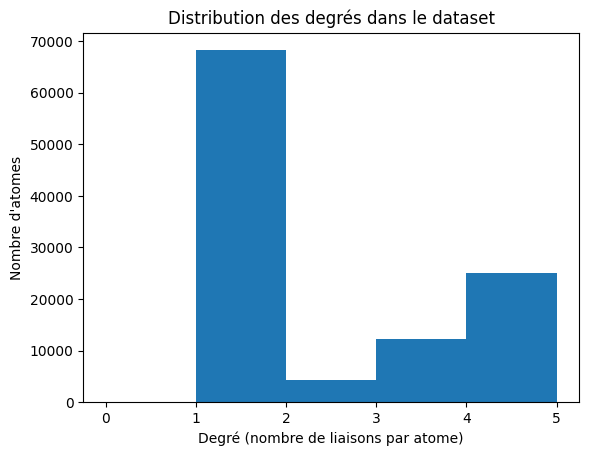

In [39]:
import torch

degrees = []
for i in range(len(dataset)):
    edge_index = dataset[i].edge_index
    deg = torch.bincount(edge_index[0], minlength=dataset[i].x.size(0)).tolist()
    degrees.extend(deg)

plt.hist(degrees, bins=range(max(degrees)+2))
plt.xlabel("Degré (nombre de liaisons par atome)")
plt.ylabel("Nombre d'atomes")
plt.title("Distribution des degrés dans le dataset")
plt.show()


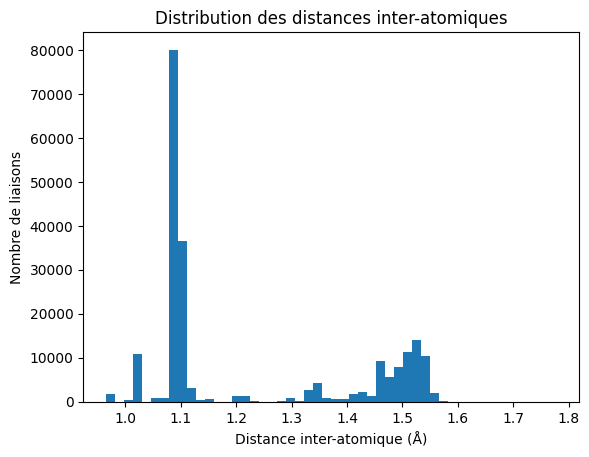

In [40]:
distances = []
for i in range(len(dataset)):
    pos = dataset[i].pos
    edge_index = dataset[i].edge_index
    for u, v in edge_index.t().tolist():
        d = torch.norm(pos[u] - pos[v]).item()
        distances.append(d)

plt.hist(distances, bins=50)
plt.xlabel("Distance inter-atomique (Å)")
plt.ylabel("Nombre de liaisons")
plt.title("Distribution des distances inter-atomiques")
plt.show()


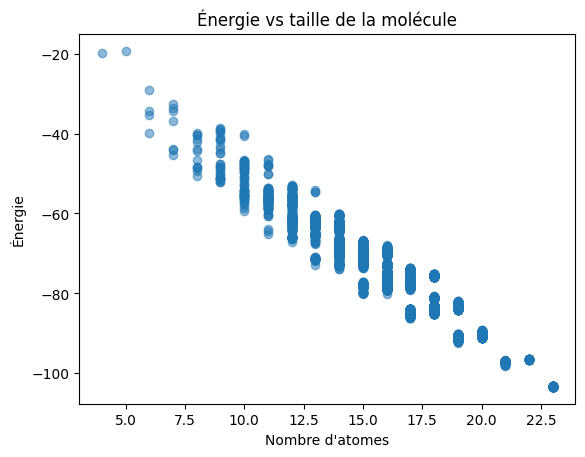

In [41]:
sizes = [dataset[i].x.size(0) for i in range(len(dataset))]
energies = [dataset[i].y.item() for i in range(len(dataset))]
plt.scatter(sizes, energies, alpha=0.5)
plt.xlabel("Nombre d'atomes")
plt.ylabel("Énergie")
plt.title("Énergie vs taille de la molécule")
plt.show()


In [55]:
import numpy as np

num_molecules = len(dataset)
num_atom_types = len(ATOM_TYPES)

X = np.zeros((num_molecules, num_atom_types), dtype=int)
y = np.zeros(num_molecules)

for i in range(num_molecules):
    data = dataset[i]
    atom_types = data.x.argmax(dim=1).tolist()
    counts = np.bincount(atom_types, minlength=num_atom_types)
    X[i, :] = counts
    y[i] = data.y.item()

print("Exemple de vecteur de caractéristiques pour molécule 0 :", X[0])
print("Énergie cible :", y[0])


Exemple de vecteur de caractéristiques pour molécule 0 : [13  6  1  0  0  0  0]
Énergie cible : -90.10787963867188


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Erreur quadratique moyenne sur test: {mse:.4f}")

# Cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Scores de validation croisée (négatif MSE) : {scores}")


Erreur quadratique moyenne sur test: 0.3082
Scores de validation croisée (négatif MSE) : [-0.30327407 -0.29145346 -0.30686539 -0.30227561 -0.31632483]


In [57]:
import os
import numpy as np
import csv
from pathlib import Path
model = LinearRegression()
model.fit(X, y)
TEST_XYZ_DIR = DATA_ROOT / "atoms" / "test"
ATOM_TYPES = ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']

def atom_to_int(symbol):
    return ATOM_TYPES.index(symbol)

def load_test_data(xyz_dir):
    X = []
    test_ids = []

    # Lister tous les fichiers .xyz
    files = sorted(os.listdir(xyz_dir))  
    for filename in files:
        if not filename.endswith(".xyz"):
            continue
        
        file_id = filename.split(".")[0]  # ex: 'id_123'
        test_ids.append(file_id)

        path = xyz_dir / filename
        with open(path, 'r') as f:
            lines = f.readlines()[2:]  # sauter les 2 premières lignes
        
        atoms = [atom_to_int(line.split()[0]) for line in lines]
        counts = np.bincount(atoms, minlength=len(ATOM_TYPES))
        X.append(counts)
    
    X = np.array(X)
    return X, test_ids

# Charger et préparer les données de test
X_test, test_ids = load_test_data(TEST_XYZ_DIR)

# Prédire avec le modèle entraîné
predictions = model.predict(X_test)

# Sauvegarder dans test.csv
with open("test.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "energy"])
    for file_id, energy_pred in zip(test_ids, predictions):
        # Extraire le numéro d'id pour correspondre au format attendu
        id_num = int(file_id.split("_")[-1])
        writer.writerow([id_num, energy_pred])


In [58]:
import torch

# Numéros atomiques pour chaque type (H=1, C=6, N=7, O=8, F=9, S=16, Cl=17)
ATOM_Z = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9,
    'S': 16,
    'Cl': 17
}

def atom_to_z(symbol):
    return ATOM_Z[symbol]

def compute_coulomb_matrix(z_tensor, pos_tensor):
    """
    z_tensor: LongTensor de taille (N_atoms) avec indices atomiques 0..6 (H..Cl)
    pos_tensor: FloatTensor (N_atoms, 3) positions
    
    Retourne matrice Coulomb (N_atoms x N_atoms) en torch.FloatTensor
    """
    # Convertir indices en numéros atomiques réels
    Z = torch.tensor([list(ATOM_Z.values())[i] for i in z_tensor], dtype=torch.float)
    
    N = len(Z)
    C = torch.zeros((N, N), dtype=torch.float)
    
    dist_matrix = torch.cdist(pos_tensor, pos_tensor) + torch.eye(N)  # ajouter 1 sur diag pour éviter div0

    for i in range(N):
        for j in range(N):
            if i == j:
                C[i,j] = 0.5 * Z[i]**2.4
            else:
                C[i,j] = (Z[i]*Z[j]) / dist_matrix[i,j]
    return C

def get_coulomb_features(z, pos, max_atoms=23):
    """
    Calcule les valeurs propres de la matrice de Coulomb triées.
    max_atoms: taille maximale pour pad/trunc (QM7X max ~23 atomes)
    
    Retourne un vecteur numpy de taille max_atoms (valeurs propres triées décroissantes)
    """
    C = compute_coulomb_matrix(z, pos)
    eigvals = torch.linalg.eigvalsh(C)  # valeurs propres réelles, triées croissantes
    eigvals = torch.flip(eigvals, dims=[0])  # trier décroissant
    
    # Pad avec des zéros si moins d’atomes
    if len(eigvals) < max_atoms:
        padding = torch.zeros(max_atoms - len(eigvals))
        eigvals = torch.cat([eigvals, padding])
    else:
        eigvals = eigvals[:max_atoms]
    return eigvals.numpy()
